In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from pathlib import Path
from tqdm import tqdm
import torch
from torch import nn
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from torchvision.transforms.v2 import Compose, Resize, Lambda, ToTensor, Grayscale, ToPILImage, ToImage, CenterCrop
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# plt.style.use('seaborn')
import PIL
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from transformers import CLIPProcessor, CLIPModel
from utils import load_datasets_ImageNet_two_transforms

torch.manual_seed(0)
np.random.seed(0)
rng = np.random.default_rng(0)

path_results = Path(os.path.dirname(os.getcwd())) / 'results'
path_dataset = os.path.expandvars('$DSDIR/imagenet') # '/scratchf/'
path_imagenet = os.path.expandvars('$DSDIR/imagenet') # '/scratchf/'
path_imagenet_labels = os.path.expandvars('$WORK/DATA/LOC_synset_mapping.txt')
path_imagenet_categories = os.path.expandvars('$WORK/DATA/imagenet_categories_synset.csv')
path_huggingface = os.path.expandvars('$DSDIR/HuggingFace_Models/') 

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
BATCH_SIZE = 512

attributes = ['sunny', 'snowing', 'raining', 'cloudy']

In [3]:
class CLIP_ZeroShot(nn.Module):
    def __init__(self, list_prompts):
        super().__init__()
        self.CLIP_model = CLIPModel.from_pretrained(path_huggingface+"openai/clip-vit-large-patch14").cuda()
        self.CLIP_processor = CLIPProcessor.from_pretrained(path_huggingface+"openai/clip-vit-large-patch14")
        self.list_prompts = list_prompts

    def forward(self, images):
        with torch.no_grad():
            inputs = self.CLIP_processor(text=self.list_prompts, images=images, return_tensors="pt", padding=True)
            for name, tensor in inputs.items():
                inputs[name] = tensor.cuda()
            outputs = self.CLIP_model(**inputs)
            logits_per_image = outputs.logits_per_image #/ self.CLIP_model.logit_scale.exp()  # this is the image-text similarity score
            # probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities
        return logits_per_image

In [4]:
# LOAD CLASSIFIER
weights = ResNet50_Weights.IMAGENET1K_V2
classifier = resnet50(weights=weights).to(device)
preprocess_classif = weights.transforms()
classifier.eval()

# LOAD CLIP
clip = CLIP_ZeroShot([f'Outdoor, it is {a} during the {d}' for a in attributes for d in ['day', 'night']])

# LOAD DATA
# dataset_train, dataset_val = load_datasets_ImageNet_two_transforms(path_dataset, BATCH_SIZE, preprocess_classif, preprocess_clip)
# dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True, shuffle=False)   
# dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True, shuffle=False)
dataset_val = ImageFolder(path_imagenet+'/val', transform=preprocess_classif)
dataset_val_clip = ImageFolder(path_imagenet+'/val', transform=Compose([ToImage(), Resize(224), CenterCrop(224)]))
dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True, shuffle=False)
dataloader_val_clip = DataLoader(dataset_val_clip, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True, shuffle=False)

idx_to_label = {}
with open(path_imagenet_labels) as f:
    for i, line in enumerate(f):
       idx_to_label[i] = line[10:-1]
idx_to_category = {}
with open(path_imagenet_categories) as f:
    for i, line in enumerate(f):
       if i>0:
        idx_to_category[i-1] = line.split(',')[-1][:-1]

In [5]:
f_path_test = path_results / 'results_SSC_ImageNet.csv'

if f_path_test.exists():
    df = pd.read_csv(f_path_test)
else:
    # Test loop
    all_confidence = []
    all_correct = []
    all_attributes_probas = []
    for (images, labels), (images_clip, _) in zip(dataloader_val, dataloader_val_clip):
        # Classifier
        images, labels = images.cuda(), labels.cuda()
        with torch.no_grad():
            logits = classifier(images)
        probas = logits.softmax(dim=1)
        confidence, pred = probas.max(1)
        correct = (pred == labels)
        all_confidence.append(confidence)
        all_correct.append(correct)
        
        # CLIP
        attributes_probas = clip(images_clip).softmax(dim=1)
        all_attributes_probas.append(attributes_probas)
        break
    all_confidence = torch.cat(all_confidence).cpu().numpy()
    all_correct = torch.cat(all_correct).cpu().numpy()
    print(f'Val accuracy {np.mean(all_correct):.2f}')

Val accuracy 0.90


In [23]:
attributes_probas[:,0]

tensor([0.4678, 0.6042, 0.6300, 0.2780, 0.2127, 0.5156, 0.6706, 0.8638, 0.5789,
        0.1215, 0.5866, 0.6933, 0.5090, 0.5747, 0.8307, 0.1323, 0.1458, 0.5835,
        0.3005, 0.0176, 0.7556, 0.1875, 0.5705, 0.0138, 0.3214, 0.0568, 0.3079,
        0.0961, 0.4796, 0.4367, 0.3699, 0.0058, 0.6942, 0.3048, 0.4723, 0.2835,
        0.0719, 0.5860, 0.1166, 0.5670, 0.6894, 0.6236, 0.2756, 0.4135, 0.7633,
        0.3761, 0.1666, 0.5971, 0.5932, 0.5607, 0.0941, 0.0948, 0.4111, 0.5308,
        0.1418, 0.1477, 0.1450, 0.1250, 0.5970, 0.2228, 0.2499, 0.3379, 0.3247,
        0.5896, 0.2354, 0.2545, 0.0886, 0.6703, 0.0603, 0.1723, 0.1481, 0.4770,
        0.3236, 0.6600, 0.4062, 0.2720, 0.4339, 0.4961, 0.0818, 0.4286, 0.2207,
        0.2603, 0.2207, 0.1468, 0.0492, 0.4417, 0.6122, 0.4942, 0.2043, 0.2124,
        0.1992, 0.3468, 0.3312, 0.3027, 0.1804, 0.3218, 0.4042, 0.4293, 0.1923,
        0.0979, 0.4751, 0.4470, 0.1537, 0.3365, 0.4701, 0.2379, 0.5535, 0.3568,
        0.3640, 0.2323, 0.4003, 0.5763, 

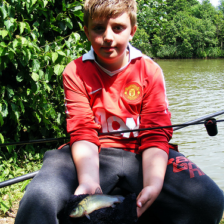

In [26]:
ToPILImage()(dataset_val_clip[2][0])

In [29]:
confidence

tensor([6.0381, 6.9704, 7.0906, 6.9044, 7.1498, 7.7462, 7.0231, 6.9253, 6.8398,
        6.6141, 5.6672, 6.4371, 6.8863, 7.1880, 6.3447, 7.1878, 6.6841, 6.3593,
        7.0507, 7.5616, 6.4050, 7.0047, 7.1186, 6.7796, 7.3495, 6.7263, 6.8195,
        6.7069, 7.2583, 8.8032, 6.8823, 7.4157, 6.5755, 6.7510, 7.2791, 7.0033,
        5.1322, 7.1149, 6.8415, 6.5776, 6.8483, 6.3987, 6.9167, 7.1066, 7.2837,
        6.7512, 7.1941, 7.1141, 6.9267, 7.0542, 5.2299, 6.8267, 7.4309, 6.7849,
        5.4340, 7.2325, 7.0466, 6.1801, 7.0486, 6.7395, 6.0241, 6.3532, 6.8803,
        7.1744, 7.2132, 6.8134, 7.1660, 5.8141, 6.4607, 6.2643, 7.2440, 6.5994,
        7.8905, 5.3409, 7.3164, 7.4482, 7.1969, 5.9736, 6.8152, 7.2234, 6.6846,
        6.2834, 6.2772, 6.8969, 6.7415, 6.6977, 7.4198, 6.2701, 6.4950, 6.2107,
        6.3985, 6.6995, 7.2048, 7.0597, 6.5907, 6.6983, 7.1056, 6.6792, 6.6026,
        5.2188, 6.9156, 6.5464, 6.7913, 6.6109, 6.4169, 6.0302, 6.5493, 5.7070,
        6.6055, 7.3720, 6.5287, 6.5140, 

In [ ]:
cosim